# LCD digits dataset shows NMF parts-based decomposition

This synthetic image dataset shows very nicely how NMF decompose images as the sums of their parts.  The collection of images is encoded as a 2d array of non-negative values.  Each row corresponds to an image, and each column corresponds to a pixel.  The non-negative entries represent the whiteness of the pixel, encoded here as a value between 0 and 1.
 
 * See also the accompanying blog post http://building-babylon.net/2016/12/28/an-lcd-digit-dataset-for-illustrating-the-parts-based-representation-of-nmf/ .
 * Original found https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

Released under Apache Licence v2.0.  I hope you find it useful.

In [2]:
length = 4  # length of any LCD cell ("stroke")
shape = (2 * length + 5, length + 4)  # shape of the images

## Code for displaying a vector as an image

In [3]:
from matplotlib import pyplot as plt

def show_as_image(vector):
    """
    Given a 1d vector representing an image, display that image in 
    black and white.  If there are negative values, then use red for 
    that pixel.
    (displaying negative pixel values in red allows e.g. visual contrasting
    of PCA and NMF components)
    """
    bitmap = vector.copy().reshape(shape)  # make a square array
    bitmap /= np.abs(vector).max()  # normalise (a copy!)
    bitmap = bitmap[:,:,np.newaxis]
    rgb_layers = [np.abs(bitmap)] + [bitmap.clip(0)] * 2
    rgb_bitmap = np.concatenate(rgb_layers, axis=-1)
    plt.figure(figsize=(2, 1))
    plt.imshow(rgb_bitmap, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Code for generating the images

In [4]:
import numpy as np

def vertical_stroke(rightness, downness):
    """
    Return a 2d numpy array representing an image with a single vertical stroke in it.
    `rightness` and `downness` are values from [0, 1] and define the position of the vertical stroke.
    """
    i = (downness * (length + 1)) + 2
    j = rightness * (length + 1) + 1
    x = np.zeros(shape=shape, dtype=np.float64)
    for delta in range(length):
        x[i + delta, j] = 1.
    return x

def horizontal_stroke(downness):
    """
    Analogue to vertical_stroke, but it returns horizontal strokes.
    `downness` is here a value in [0, 1, 2].
    """
    i = (downness * (length + 1)) + 1
    x = np.zeros(shape=shape, dtype=np.float64)
    for j in range(length):
        x[i, 2 + j] = 1.
    return x

print(horizontal_stroke(0))

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:
strokes = [horizontal_stroke(k) for k in range(3)] + [vertical_stroke(k, l) for k in range(2) for l in range(2)]

In [6]:
import random

def random_composition():
    """
    Return a random composition of 2, 3, 4, or 5 strokes as a single 2d numpy array.
    (So not guaranteed to look like a real digit!)
    """
    x = np.zeros(shape=shape, dtype=np.float64)
    num_strokes = random.choice([2, 3, 4, 5])
    sample = random.sample(strokes, num_strokes) # without replacement
    for atom in sample:
        x += atom
    return x

In [7]:
bitmap = random_composition()
print(bitmap)

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


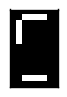

In [8]:
show_as_image(bitmap.flatten())

## Generate the dataset

In [9]:
N = 200
samples = [random_composition().flatten() for _ in range(N)]
X = np.vstack(samples)
print(X.shape)

(200, 104)


## Learning the individual cells with a Keras based NNMF

Based on formula (1) from http://www.cs.princeton.edu/courses/archive/spring12/cos424/pdf/lee-seung.pdf, an image $i$ from our dataset $X$ is approximated by a weighted combination $\mathbf{W}_i$ of $k=1, \cdots, K$ basis images $\mathbf{H}_k$.

$$ \mathbf{X}_i \approx \mathbf{W}_i \mathbf{H} = \sum_{k=1}^K \mathbf{W}_{ik} \mathbf{H}_{k}$$

We can express this formula into a two layers neural network:

 1. Given an image id $i$, find its coordinates $\mathbf{W}_i$ in terms of basis images 

$\Rightarrow$ our input will be a simple vector of row indexes `X_image_ids` and `keras.layers.Embedding` will mapped each id $i$ into its embedding $\mathbf{W}_i$

 2. (1bis) Reshape the embedding into `Reshape((embedding_size,))`

 2. Given a set coordinates/weights $\mathbf{W}_i$, multiply with $\mathbf{H}$ to reconstruct the image 

$\Rightarrow$ this simply translates as a `keras.layers.Dense` layer with `output_dim` equals to the number of pixels and no biases 


In [19]:
import tensorflow as tf

import keras
from keras.layers import Embedding, Reshape, Dense, Activation
from keras.models import Sequential
from keras.constraints import nonneg

from keras import backend as K

sess = tf.InteractiveSession()
K.set_session(sess)

print(tf.__version__)
print(keras.__version__)


n_images, n_pixels = X.shape
K = embedding_size = 7

X_image_ids = np.arange(n_images)

X_image_ids[:10]

0.12.0-rc0
1.1.0


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
### EXERCISE 
# initialise a 
# model = Sequential(...)
# with all the 3 layers listed above
# You can test it by doing 
# show_as_image(X[1])
# show_as_image(model.predict(np.array([[0]])))
# which should show some random prediction as the model is not trained yet

In [26]:
### SOLUTION ###





weights_contraint = None
image_to_embeddings = Embedding(input_dim=n_images, output_dim=embedding_size, input_length=1, init='uniform', W_constraint=weights_contraint)

embeddings_to_images = Dense(output_dim=n_pixels, bias=False, W_constraint=weights_contraint)

model = Sequential([
    image_to_embeddings,
    Reshape((embedding_size,)), # getting rid of the superfluous dimension of input_length=1
    embeddings_to_images])

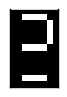

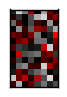

In [21]:
show_as_image(X[1])
show_as_image(model.predict(np.array([[0]])))

In [29]:
### EXERCISE 
# compile the model using mean_squared_error and Adam optimizer
# then fit the model by feeding X_images and X as x/y
# use fit(..., batch_size=n_images, verbose=0, nb_epoch=1000)

# Check your result by looking at the predicted image as above
from keras.optimizers import Adam

In [22]:
### SOLUTION






from keras.optimizers import Adam

model.compile(loss='mean_squared_error', optimizer=Adam())

X_image_ids = np.arange(n_images)

model.fit(
    x=X_image_ids, 
    y=X,
    batch_size=n_images, verbose=0, nb_epoch=1000)
          
#repeats = 1000
#model.fit(x=np.tile(X_image_ids, repeats), y=np.tile(X, (repeats, 1)),
#          batch_size=n_images, verbose=2, nb_epoch=10)

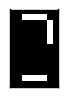

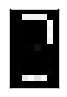

In [23]:
show_as_image(X[0])
show_as_image(model.predict(np.array([[0]])))

## Visualising the basis of images learnt

 * A vanilla neural net will converge to a basis of images with good predictive power but not meaningful  
 * Go back to the `model` above and use `keras.constraints.nonneg` (look at doc) to add positive constraints on the layers and look at the learnt basis (each basis image should be one of the 7 cells)

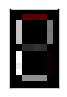

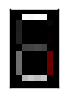

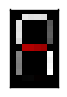

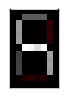

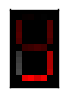

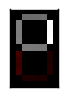

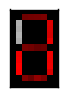

In [24]:
for component in embeddings_to_images.weights[0].eval():
    show_as_image(component)